In [1]:
import os
import ast
from collections import Counter
from typing import Tuple, List, Union, Dict

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
with open('./Sarcasm_Headlines_Dataset.json', mode='r') as f:
    data = f.readlines()

article_links: list = []
is_sarcastic: list = []
headlines: list = []

for line in data:
    line = ast.literal_eval(line)
    article_links.append(line['article_link'])
    is_sarcastic.append(line['is_sarcastic'])
    headlines.append(line['headline'])

In [3]:
# Count Number of Sarcastic Text and Non-Sarcastic Text
Counter(is_sarcastic)

Counter({0: 14985, 1: 11724})

In [4]:
def split_data(
    data: List, 
    target: Union[int, None] = None, 
    test_size: Union[int, float]=0.2
    ) -> Union[Tuple[Tuple[List, List], Tuple[List, List]], Tuple[List, List]]:
    data_len = len(data)
    if isinstance(test_size, float):
        test_len = int(data_len * test_size)
    elif isinstance(test_size, int):
        pass

    if target:
        # Return (X_train, y_train), (X_test, y_test)
        return (data[:-test_len], target[:-test_len]), (data[-test_len:], target[-test_len:])
    else:
        # Return (X_train, X_test)
        return (data[:-test_len], data[-test_len:])

(train_headlines, train_is_sarcastic), (valid_headlines, valid_is_sarcastic)  = split_data(
    headlines, 
    target=is_sarcastic,
    test_size=0.2
    )

In [5]:
vocab_size: int = 10000
oov_token: str = '<UNK>'
max_length: int = 40
embedding_size: int = 20
padding_type = 'post'
truncating_type: str = 'post'
epochs: int = 20

In [6]:
tokenizer = Tokenizer(
    num_words=vocab_size,
    lower=True,
    oov_token=oov_token
)
tokenizer.fit_on_texts(train_headlines)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_headlines)
valid_sequences = tokenizer.texts_to_sequences(valid_headlines)

# Check Maximum Length of Texts
# print('Text Max Len:', max([len(_) for _ in train_sequences]))
# Should be ~40

train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=truncating_type
    )
valid_padded = pad_sequences(
    valid_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=truncating_type
    )

In [7]:
train_is_sarcastic = np.array(train_is_sarcastic)
valid_is_sarcastic = np.array(valid_is_sarcastic)

Epoch 1/20
668/668 [==============================] - 2s 2ms/step - loss: 0.6629 - accuracy: 0.5794 - val_loss: 0.6248 - val_accuracy: 0.6504
INFO:tensorflow:Assets written to: ./assets
Epoch 2/20
668/668 [==============================] - 2s 3ms/step - loss: 0.5711 - accuracy: 0.7529 - val_loss: 0.5222 - val_accuracy: 0.7852
INFO:tensorflow:Assets written to: ./assets
Epoch 3/20
668/668 [==============================] - 3s 4ms/step - loss: 0.4726 - accuracy: 0.8164 - val_loss: 0.4500 - val_accuracy: 0.8124
INFO:tensorflow:Assets written to: ./assets
Epoch 4/20
668/668 [==============================] - 3s 4ms/step - loss: 0.4113 - accuracy: 0.8355 - val_loss: 0.4131 - val_accuracy: 0.8272
INFO:tensorflow:Assets written to: ./assets
Epoch 5/20
668/668 [==============================] - 3s 4ms/step - loss: 0.3744 - accuracy: 0.8472 - val_loss: 0.3926 - val_accuracy: 0.8334
INFO:tensorflow:Assets written to: ./assets
Epoch 6/20
668/668 [==============================] - 3s 4ms/step - lo

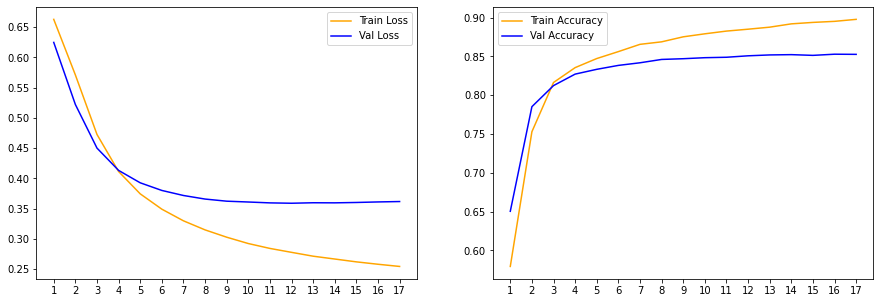

In [8]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
], name='Sentiment_Detector')

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5
)
model_checkpt = ModelCheckpoint(
    filepath='.'
)

history = model.fit(
    x=train_padded,
    y=train_is_sarcastic, 
    batch_size=32,
    epochs=epochs,
    validation_data=(valid_padded, valid_is_sarcastic),
    callbacks=[early_stopping, model_checkpt]
)

def plot_loss_acc(history: Union[tf.keras.callbacks.History, Dict]):
    if isinstance(history, tf.keras.callbacks.History):
        history = history.history
    elif isinstance(history, dict):
        pass
    else:
        raise TypeError

    epochs_axis = list(map(int, list(range(1, len(history['loss'])+1))))
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    ax1.plot(epochs_axis, history['loss'], color='orange', label='Train Loss')
    ax1.plot(epochs_axis, history['val_loss'], color='b', label='Val Loss')
    ax1.set_xticks(ticks=epochs_axis)
    ax1.legend()

    ax2.plot(epochs_axis, history['accuracy'], color='orange', label='Train Accuracy')
    ax2.plot(epochs_axis, history['val_accuracy'], color='b', label='Val Accuracy')
    ax2.set_xticks(ticks=epochs_axis)
    ax2.legend()
    plt.show()

plot_loss_acc(history)